# Random Forest: Ensemble Learning

## Overview

**Random Forest** is an ensemble learning method that combines multiple decision trees to create a more robust and accurate model. It uses **bagging** (bootstrap aggregating) and **feature randomness** to reduce overfitting and improve generalization.

## Key Concepts

### Ensemble Learning

**Wisdom of the Crowd**:
\[
\text{Final Prediction} = \text{Aggregate}(\text{Tree}_1, \text{Tree}_2, \ldots, \text{Tree}_n)
\]

**Classification**: Majority voting
\[
\hat{y} = \text{mode}(h_1(x), h_2(x), \ldots, h_n(x))
\]

**Regression**: Average prediction
\[
\hat{y} = \frac{1}{n}\sum_{i=1}^{n} h_i(x)
\]

### Bootstrap Aggregating (Bagging)

1. Create \(n\) bootstrap samples (sampling with replacement)
2. Train one tree on each sample
3. Aggregate predictions

Each bootstrap sample contains ~63.2% unique samples from original dataset.

### Feature Randomness

At each split, consider only a **random subset** of features:
- Classification: \(\sqrt{p}\) features (default)
- Regression: \(p/3\) features (default)

where \(p\) is total number of features.

### Out-of-Bag (OOB) Score

- Each tree is trained on ~63% of data
- Remaining ~37% (out-of-bag) used for validation
- OOB score approximates test performance without separate validation set

## Topics Covered

1. Random Forest Classification
2. Random Forest Regression
3. Out-of-Bag evaluation
4. Feature importance (impurity-based and permutation)
5. Hyperparameter tuning
6. Comparison with single decision trees
7. Real-world applications
8. Partial dependence plots

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    mean_squared_error, r2_score, roc_auc_score, roc_curve
)
from sklearn.datasets import (
    make_classification, make_regression, load_iris, load_wine,
    load_breast_cancer, load_diabetes, fetch_california_housing
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

np.random.seed(42)
sns.set_style('whitegrid')
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. Random Forest Classification

### 1.1 Comparison with Single Tree

In [2]:
# Generate dataset
X, y = make_classification(
    n_samples=500,
    n_features=10,
    n_informative=8,
    n_redundant=2,
    random_state=42
)

print("Classification Dataset")
print("="*70)
print(f"Samples: {X.shape[0]}")
print(f"Features: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")
print(f"Class distribution: {np.bincount(y)}")

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"\nTrain: {X_train.shape[0]}, Test: {X_test.shape[0]}")

Classification Dataset
Samples: 500
Features: 10
Classes: [0 1]
Class distribution: [250 250]

Train: 350, Test: 150


In [3]:
# Train single decision tree
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)

# Train random forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Compare performance
print("Single Decision Tree vs Random Forest")
print("="*70)

models = {
    'Single Decision Tree': single_tree,
    'Random Forest (100 trees)': rf
}

for name, model in models.items():
    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    
    print(f"\n{name}:")
    print(f"  Train Accuracy: {train_acc:.4f}")
    print(f"  Test Accuracy:  {test_acc:.4f}")
    print(f"  Overfitting Gap: {train_acc - test_acc:.4f}")
    
    if hasattr(model, 'get_depth'):
        print(f"  Tree depth: {model.get_depth()}")
        print(f"  Leaves: {model.get_n_leaves()}")

print("\n💡 Key Observations:")
print("  - Random Forest reduces overfitting compared to single tree")
print("  - Better generalization (higher test accuracy)")
print("  - More stable predictions through averaging")

Single Decision Tree vs Random Forest

Single Decision Tree:
  Train Accuracy: 1.0000
  Test Accuracy:  0.6333
  Overfitting Gap: 0.3667
  Tree depth: 10
  Leaves: 43

Random Forest (100 trees):
  Train Accuracy: 1.0000
  Test Accuracy:  0.8133
  Overfitting Gap: 0.1867

💡 Key Observations:
  - Random Forest reduces overfitting compared to single tree
  - Better generalization (higher test accuracy)
  - More stable predictions through averaging


### 1.2 Out-of-Bag (OOB) Evaluation

In [4]:
# Train with OOB score
rf_oob = RandomForestClassifier(
    n_estimators=100,
    oob_score=True,
    random_state=42
)
rf_oob.fit(X_train, y_train)

print("Out-of-Bag (OOB) Evaluation")
print("="*70)
print(f"OOB Score: {rf_oob.oob_score_:.4f}")
print(f"Test Score: {rf_oob.score(X_test, y_test):.4f}")

print("\nWhat is OOB?")
print("  - Each tree trained on ~63% of data (bootstrap sample)")
print("  - Remaining ~37% (out-of-bag) used for validation")
print("  - OOB score approximates cross-validation without extra computation")
print("  - Usually close to test performance")

# Compare OOB vs cross-validation
cv_scores = cross_val_score(rf_oob, X_train, y_train, cv=5)
print(f"\n5-Fold CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print(f"OOB Score:       {rf_oob.oob_score_:.4f}")
print("\n✓ OOB provides a good estimate without cross-validation!")

Out-of-Bag (OOB) Evaluation
OOB Score: 0.8514
Test Score: 0.8133

What is OOB?
  - Each tree trained on ~63% of data (bootstrap sample)
  - Remaining ~37% (out-of-bag) used for validation
  - OOB score approximates cross-validation without extra computation
  - Usually close to test performance

5-Fold CV Score: 0.8571 (+/- 0.0350)
OOB Score:       0.8514

✓ OOB provides a good estimate without cross-validation!


## 2. Feature Importance

### 2.1 Impurity-Based Importance

Feature Importance (Impurity-Based)
  Feature  Importance      Std
Feature 0    0.205199 0.062341
Feature 5    0.149686 0.059221
Feature 9    0.146536 0.063330
Feature 6    0.109214 0.057833
Feature 2    0.080330 0.041846
Feature 1    0.071714 0.040883
Feature 4    0.070778 0.037466
Feature 8    0.059960 0.039847
Feature 3    0.054274 0.032976
Feature 7    0.052308 0.033767


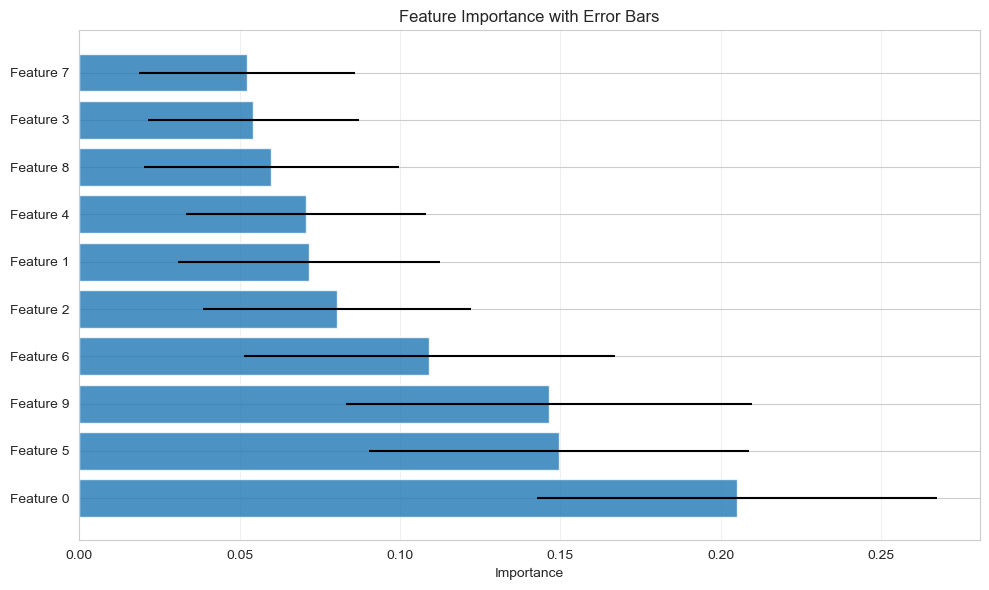


💡 How it works:
  - Measures average impurity decrease across all trees
  - Higher value = feature contributes more to predictions
  - Sum of all importances = 1.0


In [5]:
# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

feature_importance_df = pd.DataFrame({
    'Feature': [f'Feature {i}' for i in range(X.shape[1])],
    'Importance': importances,
    'Std': std
}).sort_values('Importance', ascending=False)

print("Feature Importance (Impurity-Based)")
print("="*70)
print(feature_importance_df.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], 
        feature_importance_df['Importance'],
        xerr=feature_importance_df['Std'],
        alpha=0.8)
plt.xlabel('Importance')
plt.title('Feature Importance with Error Bars')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 How it works:")
print("  - Measures average impurity decrease across all trees")
print("  - Higher value = feature contributes more to predictions")
print("  - Sum of all importances = 1.0")

## 3. Real Example: Iris Classification

### 3.1 Train and Evaluate

Iris Dataset with Random Forest
Samples: 150
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Classes: ['setosa' 'versicolor' 'virginica']

Performance:
  Train Accuracy: 1.0000
  Test Accuracy:  0.8889
  OOB Score:      0.9524

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45



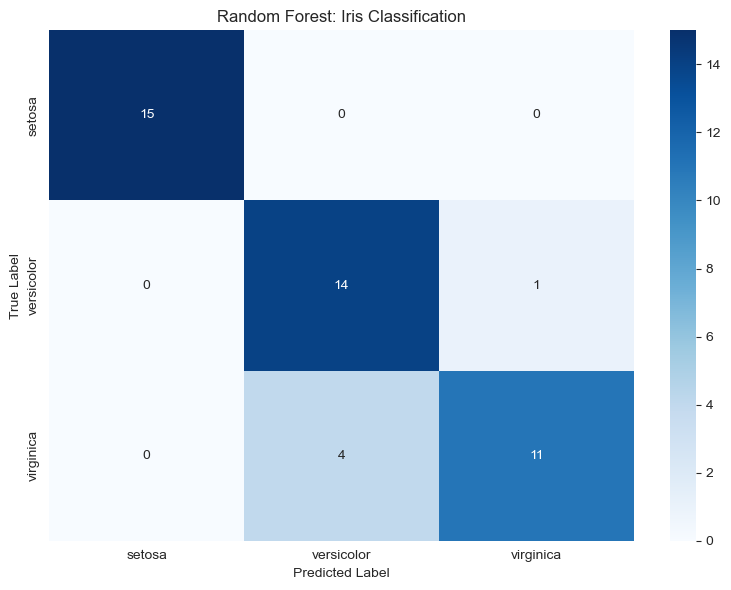

In [6]:
# Load iris
iris = load_iris()
X_iris = iris.data
y_iris = iris.target

print("Iris Dataset with Random Forest")
print("="*70)
print(f"Samples: {X_iris.shape[0]}")
print(f"Features: {iris.feature_names}")
print(f"Classes: {iris.target_names}")

# Split
X_train_iris, X_test_iris, y_train_iris, y_test_iris = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

# Train random forest
rf_iris = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    oob_score=True,
    random_state=42
)
rf_iris.fit(X_train_iris, y_train_iris)

# Evaluate
train_acc = rf_iris.score(X_train_iris, y_train_iris)
test_acc = rf_iris.score(X_test_iris, y_test_iris)
oob_score = rf_iris.oob_score_

print(f"\nPerformance:")
print(f"  Train Accuracy: {train_acc:.4f}")
print(f"  Test Accuracy:  {test_acc:.4f}")
print(f"  OOB Score:      {oob_score:.4f}")

# Predictions
y_pred_iris = rf_iris.predict(X_test_iris)

print(f"\nClassification Report:")
print(classification_report(y_test_iris, y_pred_iris, target_names=iris.target_names))

# Confusion matrix
cm = confusion_matrix(y_test_iris, y_pred_iris)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=iris.target_names,
            yticklabels=iris.target_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Random Forest: Iris Classification')
plt.tight_layout()
plt.show()

Feature Importance: Iris Classification
          Feature  Importance      Std
 petal width (cm)    0.454769 0.324072
petal length (cm)    0.401161 0.322774
sepal length (cm)    0.121437 0.175732
 sepal width (cm)    0.022633 0.032668


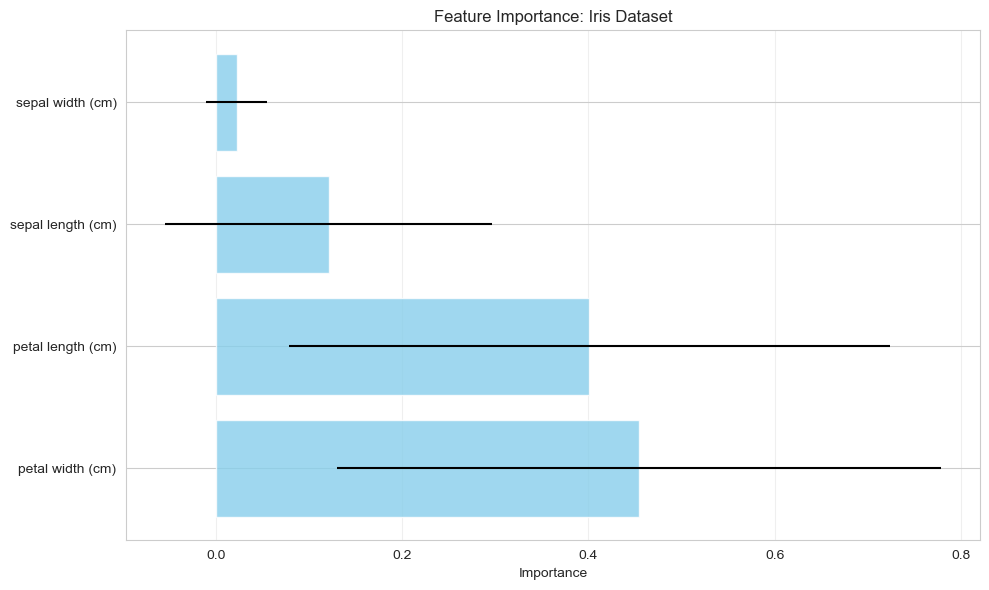


💡 Insights:
  Most important: petal width (cm)
  Least important: sepal width (cm)


In [7]:
# Feature importance for iris
importances_iris = rf_iris.feature_importances_
std_iris = np.std([tree.feature_importances_ for tree in rf_iris.estimators_], axis=0)

feature_importance_iris = pd.DataFrame({
    'Feature': iris.feature_names,
    'Importance': importances_iris,
    'Std': std_iris
}).sort_values('Importance', ascending=False)

print("Feature Importance: Iris Classification")
print("="*70)
print(feature_importance_iris.to_string(index=False))

# Plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_iris['Feature'], 
        feature_importance_iris['Importance'],
        xerr=feature_importance_iris['Std'],
        alpha=0.8, color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance: Iris Dataset')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 Insights:")
print(f"  Most important: {feature_importance_iris.iloc[0]['Feature']}")
print(f"  Least important: {feature_importance_iris.iloc[-1]['Feature']}")

## 4. Random Forest Regression

### 4.1 Diabetes Dataset

In [8]:
# Load diabetes dataset
diabetes = load_diabetes()
X_diabetes = diabetes.data
y_diabetes = diabetes.target

print("Diabetes Dataset - Random Forest Regression")
print("="*70)
print(f"Samples: {X_diabetes.shape[0]}")
print(f"Features: {X_diabetes.shape[1]}")
print(f"Feature names: {diabetes.feature_names}")

# Split
X_train_db, X_test_db, y_train_db, y_test_db = train_test_split(
    X_diabetes, y_diabetes, test_size=0.2, random_state=42
)

# Compare single tree vs random forest
models_reg = {
    'Single Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, oob_score=True)
}

print("\nModel Comparison:")
print("="*70)

for name, model in models_reg.items():
    model.fit(X_train_db, y_train_db)
    
    y_train_pred = model.predict(X_train_db)
    y_test_pred = model.predict(X_test_db)
    
    train_r2 = r2_score(y_train_db, y_train_pred)
    test_r2 = r2_score(y_test_db, y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train_db, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test_db, y_test_pred))
    
    print(f"\n{name}:")
    print(f"  Train R²: {train_r2:.4f}, Test R²: {test_r2:.4f}")
    print(f"  Train RMSE: {train_rmse:.2f}, Test RMSE: {test_rmse:.2f}")
    
    if hasattr(model, 'oob_score_'):
        print(f"  OOB R²: {model.oob_score_:.4f}")

# Keep RF model for further analysis
rf_diabetes = models_reg['Random Forest']

Diabetes Dataset - Random Forest Regression
Samples: 442
Features: 10
Feature names: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

Model Comparison:

Single Decision Tree:
  Train R²: 1.0000, Test R²: 0.0607
  Train RMSE: 0.00, Test RMSE: 70.55

Random Forest:
  Train R²: 0.9242, Test R²: 0.4428
  Train RMSE: 21.46, Test RMSE: 54.33
  OOB R²: 0.4461


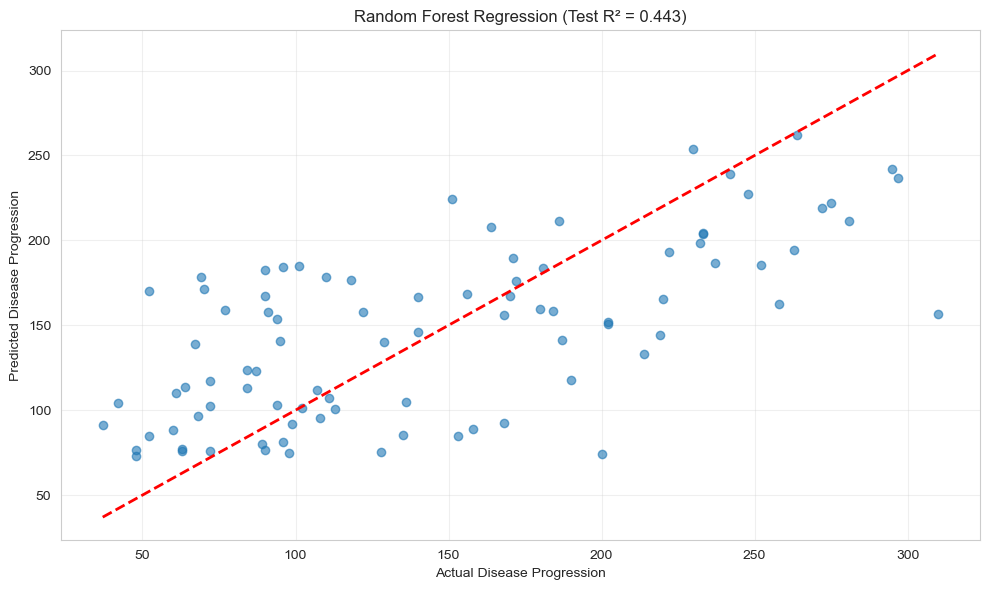


Feature Importance: Diabetes Progression
Feature  Importance
    bmi    0.355469
     s5    0.230957
     bp    0.088408
     s6    0.071329
    age    0.058642
     s2    0.057227
     s1    0.052784
     s3    0.051339
     s4    0.024213
    sex    0.009633


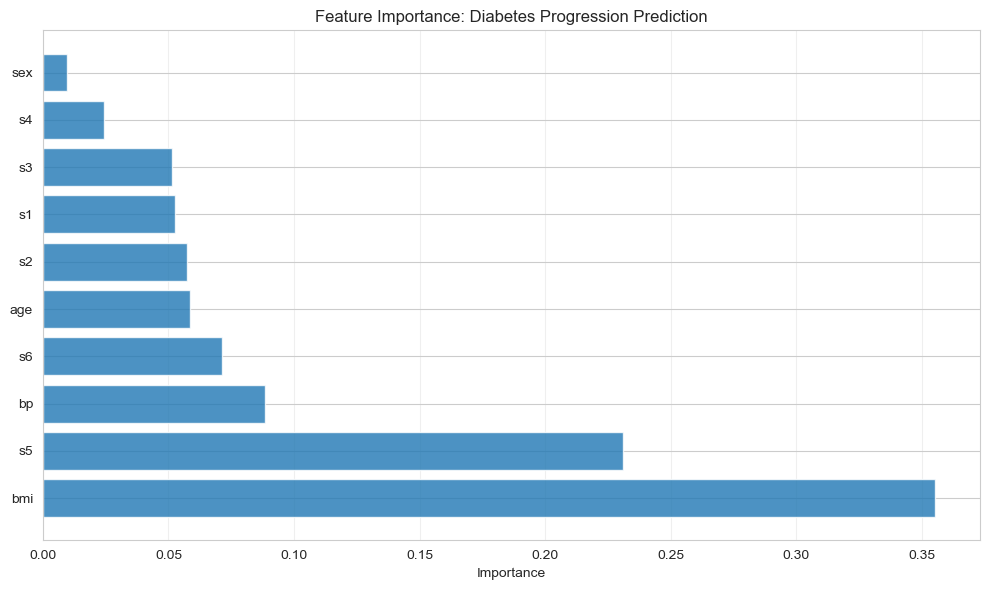

In [9]:
# Visualize predictions
y_pred_db = rf_diabetes.predict(X_test_db)

plt.figure(figsize=(10, 6))
plt.scatter(y_test_db, y_pred_db, alpha=0.6)
plt.plot([y_test_db.min(), y_test_db.max()], 
         [y_test_db.min(), y_test_db.max()], 'r--', lw=2)
plt.xlabel('Actual Disease Progression')
plt.ylabel('Predicted Disease Progression')
plt.title(f'Random Forest Regression (Test R² = {test_r2:.3f})')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Feature importance
importances_db = rf_diabetes.feature_importances_
feature_importance_db = pd.DataFrame({
    'Feature': diabetes.feature_names,
    'Importance': importances_db
}).sort_values('Importance', ascending=False)

print("\nFeature Importance: Diabetes Progression")
print("="*70)
print(feature_importance_db.to_string(index=False))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_db['Feature'], 
        feature_importance_db['Importance'], alpha=0.8)
plt.xlabel('Importance')
plt.title('Feature Importance: Diabetes Progression Prediction')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

## 5. Hyperparameter Tuning

### 5.1 Key Hyperparameters

In [10]:
print("Random Forest Hyperparameters")
print("="*70)

hyperparams = [
    ("n_estimators", "Number of trees", "More = better (diminishing returns)"),
    ("max_depth", "Maximum tree depth", "Control individual tree complexity"),
    ("min_samples_split", "Min samples to split", "Prevent overfitting"),
    ("min_samples_leaf", "Min samples per leaf", "Smoother predictions"),
    ("max_features", "Features per split", "sqrt (clf), 1/3 (reg) default"),
    ("max_samples", "Samples per tree", "Bootstrap sample size"),
    ("bootstrap", "Use bootstrap sampling", "True = bagging, False = pasting"),
]

for param, desc, effect in hyperparams:
    print(f"\n{param}:")
    print(f"  {desc}")
    print(f"  {effect}")

Random Forest Hyperparameters

n_estimators:
  Number of trees
  More = better (diminishing returns)

max_depth:
  Maximum tree depth
  Control individual tree complexity

min_samples_split:
  Min samples to split
  Prevent overfitting

min_samples_leaf:
  Min samples per leaf
  Smoother predictions

max_features:
  Features per split
  sqrt (clf), 1/3 (reg) default

max_samples:
  Samples per tree
  Bootstrap sample size

bootstrap:
  Use bootstrap sampling
  True = bagging, False = pasting


### 5.2 Effect of Number of Trees

/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/ensemble/_forest.py:612: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


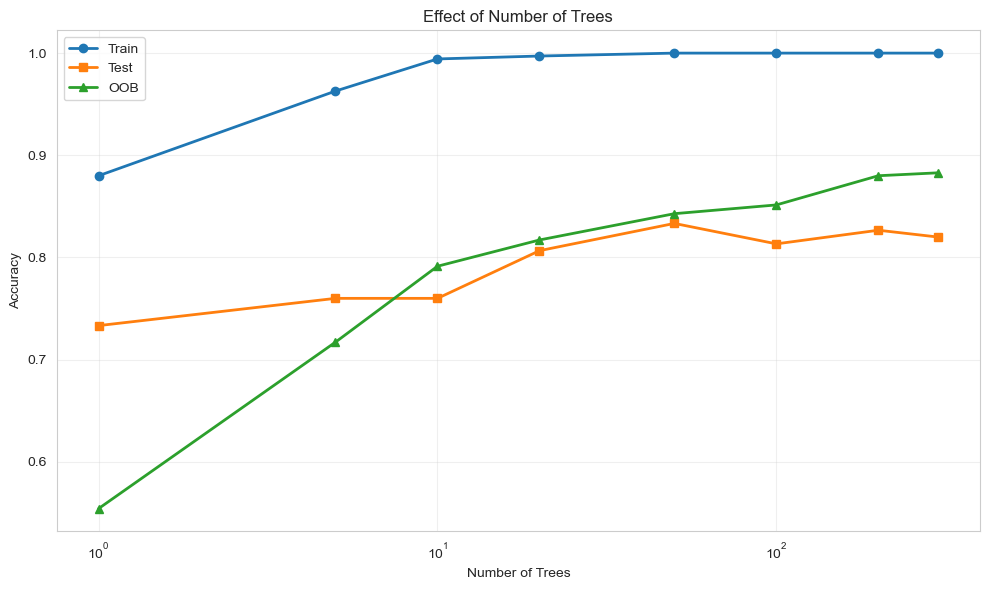


💡 Observations:
  - Performance improves rapidly up to ~50 trees
  - Diminishing returns after ~100 trees
  - More trees = more computation but no overfitting
  - OOB score tracks test performance well


In [11]:
# Test different numbers of trees
n_estimators_range = [1, 5, 10, 20, 50, 100, 200, 300]
train_scores = []
test_scores = []
oob_scores = []

for n in n_estimators_range:
    rf_temp = RandomForestClassifier(
        n_estimators=n,
        oob_score=True,
        random_state=42,
        n_jobs=-1
    )
    rf_temp.fit(X_train, y_train)
    
    train_scores.append(rf_temp.score(X_train, y_train))
    test_scores.append(rf_temp.score(X_test, y_test))
    oob_scores.append(rf_temp.oob_score_)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, train_scores, 'o-', label='Train', linewidth=2)
plt.plot(n_estimators_range, test_scores, 's-', label='Test', linewidth=2)
plt.plot(n_estimators_range, oob_scores, '^-', label='OOB', linewidth=2)
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Effect of Number of Trees')
plt.legend()
plt.grid(alpha=0.3)
plt.xscale('log')
plt.tight_layout()
plt.show()

print("\n💡 Observations:")
print("  - Performance improves rapidly up to ~50 trees")
print("  - Diminishing returns after ~100 trees")
print("  - More trees = more computation but no overfitting")
print("  - OOB score tracks test performance well")

### 5.3 Grid Search for Optimal Parameters

In [12]:
# Randomized search (faster for Random Forests)
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

random_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

print("Randomized Search for Optimal Hyperparameters")
print("="*70)
print("Searching 20 random parameter combinations...\n")

random_search.fit(X_train, y_train)

print("\nBest Parameters:")
for param, value in random_search.best_params_.items():
    print(f"  {param}: {value}")

print(f"\nBest CV Score: {random_search.best_score_:.4f}")

# Evaluate on test set
best_rf = random_search.best_estimator_
test_acc = best_rf.score(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

Randomized Search for Optimal Hyperparameters
Searching 20 random parameter combinations...

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters:
  n_estimators: 50
  min_samples_split: 2
  min_samples_leaf: 1
  max_features: log2
  max_depth: 10

Best CV Score: 0.8629
Test Accuracy: 0.8133


## 6. Real-World Application: Breast Cancer Detection

### 6.1 Complete Pipeline

In [13]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

print("Breast Cancer Detection with Random Forest")
print("="*70)
print(f"Samples: {X_cancer.shape[0]}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer.target_names}")

# Split
X_train_cancer, X_test_cancer, y_train_cancer, y_test_cancer = train_test_split(
    X_cancer, y_cancer, test_size=0.2, random_state=42, stratify=y_cancer
)

# Train optimized random forest
rf_cancer = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    oob_score=True,
    random_state=42,
    n_jobs=-1
)
rf_cancer.fit(X_train_cancer, y_train_cancer)

# Evaluate
y_pred_cancer = rf_cancer.predict(X_test_cancer)
y_proba_cancer = rf_cancer.predict_proba(X_test_cancer)[:, 1]

test_acc = accuracy_score(y_test_cancer, y_pred_cancer)
test_auc = roc_auc_score(y_test_cancer, y_proba_cancer)
oob_score = rf_cancer.oob_score_

print(f"\nPerformance:")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  AUC: {test_auc:.4f}")
print(f"  OOB Score: {oob_score:.4f}")

print(f"\nClassification Report:")
print(classification_report(y_test_cancer, y_pred_cancer, 
                          target_names=cancer.target_names))

Breast Cancer Detection with Random Forest
Samples: 569
Features: 30
Classes: ['malignant' 'benign']

Performance:
  Test Accuracy: 0.9561
  AUC: 0.9940
  OOB Score: 0.9560

Classification Report:
              precision    recall  f1-score   support

   malignant       0.95      0.93      0.94        42
      benign       0.96      0.97      0.97        72

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



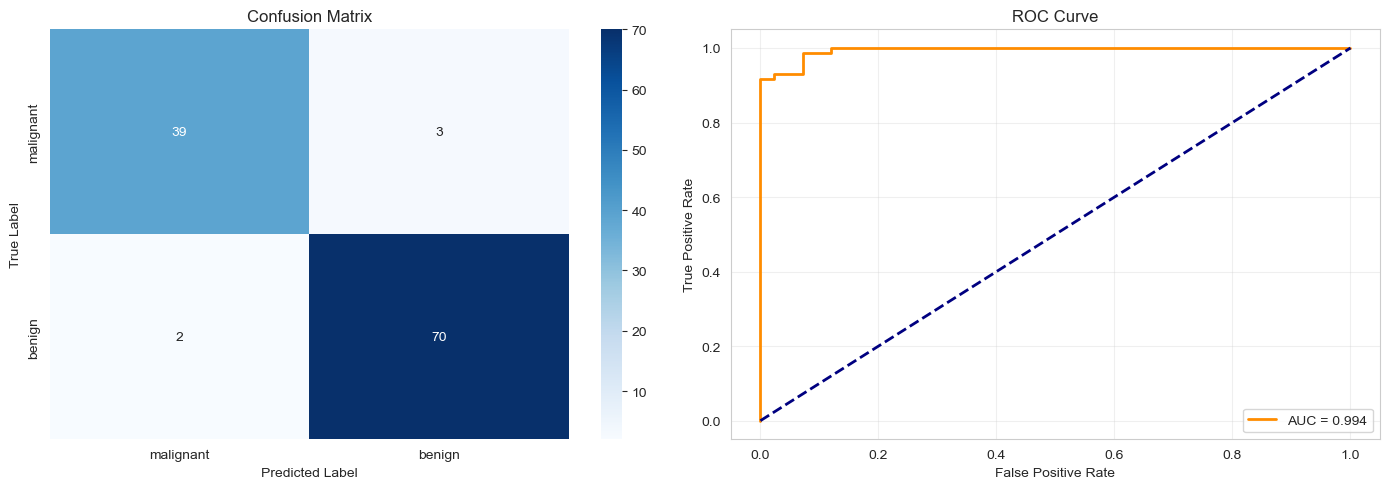

In [14]:
# Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
cm = confusion_matrix(y_test_cancer, y_pred_cancer)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=cancer.target_names,
            yticklabels=cancer.target_names,
            ax=axes[0])
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')
axes[0].set_title('Confusion Matrix')

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_cancer, y_proba_cancer)
axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {test_auc:.3f}')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend(loc='lower right')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

Top 15 Features for Cancer Detection
             Feature  Importance      Std
     worst perimeter    0.136908 0.260576
          worst area    0.130447 0.250075
worst concave points    0.107958 0.216550
 mean concave points    0.099957 0.226627
        worst radius    0.095041 0.225762
         mean radius    0.060444 0.174071
      mean perimeter    0.058497 0.167751
           mean area    0.051360 0.158046
      mean concavity    0.046409 0.139895
          area error    0.034461 0.110887
     worst concavity    0.033537 0.098254
    mean compactness    0.017488 0.074507
       worst texture    0.016874 0.025228
   worst compactness    0.014043 0.047061
        mean texture    0.012932 0.020495


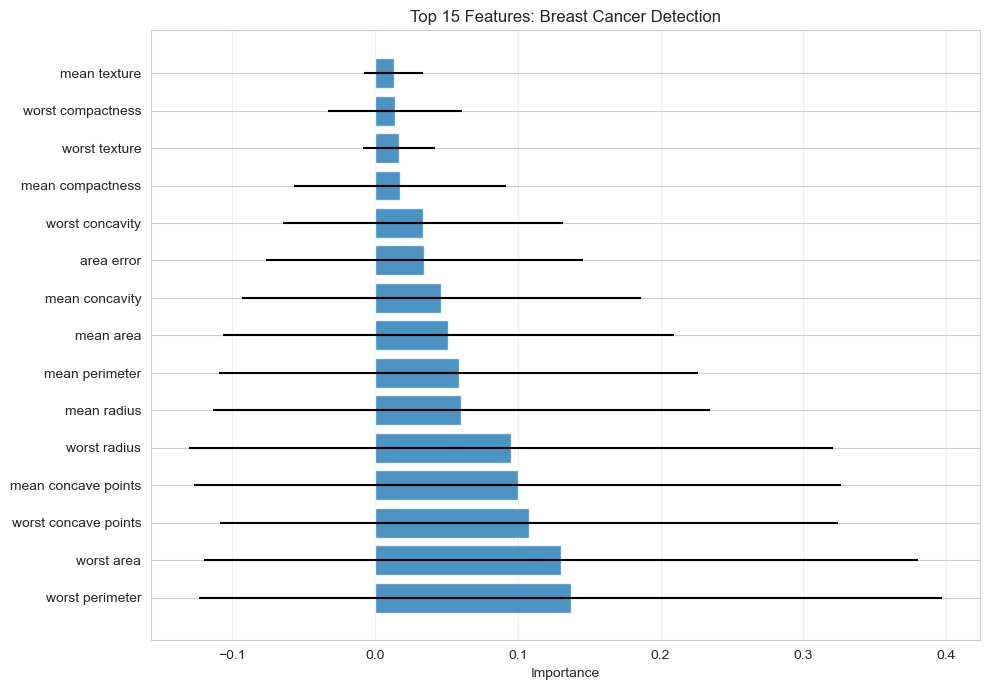

In [15]:
# Top features
importances_cancer = rf_cancer.feature_importances_
std_cancer = np.std([tree.feature_importances_ for tree in rf_cancer.estimators_], axis=0)

feature_importance_cancer = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': importances_cancer,
    'Std': std_cancer
}).sort_values('Importance', ascending=False).head(15)

print("Top 15 Features for Cancer Detection")
print("="*70)
print(feature_importance_cancer.to_string(index=False))

# Plot
plt.figure(figsize=(10, 7))
plt.barh(feature_importance_cancer['Feature'], 
        feature_importance_cancer['Importance'],
        xerr=feature_importance_cancer['Std'],
        alpha=0.8)
plt.xlabel('Importance')
plt.title('Top 15 Features: Breast Cancer Detection')
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

### 6.2 Permutation Importance (Model-Agnostic)

Permutation Importance (Top 15)
                Feature  Importance      Std
          worst texture    0.006140 0.004020
   worst concave points    0.005263 0.004297
           mean texture    0.004386 0.004386
              mean area    0.004386 0.004386
    mean concave points    0.004386 0.004386
        worst concavity    0.003509 0.004297
       worst smoothness    0.002632 0.004020
           worst radius    0.000877 0.007287
            mean radius    0.000000 0.000000
         worst symmetry    0.000000 0.000000
      worst compactness    0.000000 0.000000
fractal dimension error    0.000000 0.000000
         symmetry error    0.000000 0.000000
   concave points error    0.000000 0.000000
        concavity error    0.000000 0.000000

💡 Permutation Importance:
  - Shuffle each feature and measure performance drop
  - More reliable than impurity-based importance
  - Works with any model (model-agnostic)
  - Accounts for feature interactions


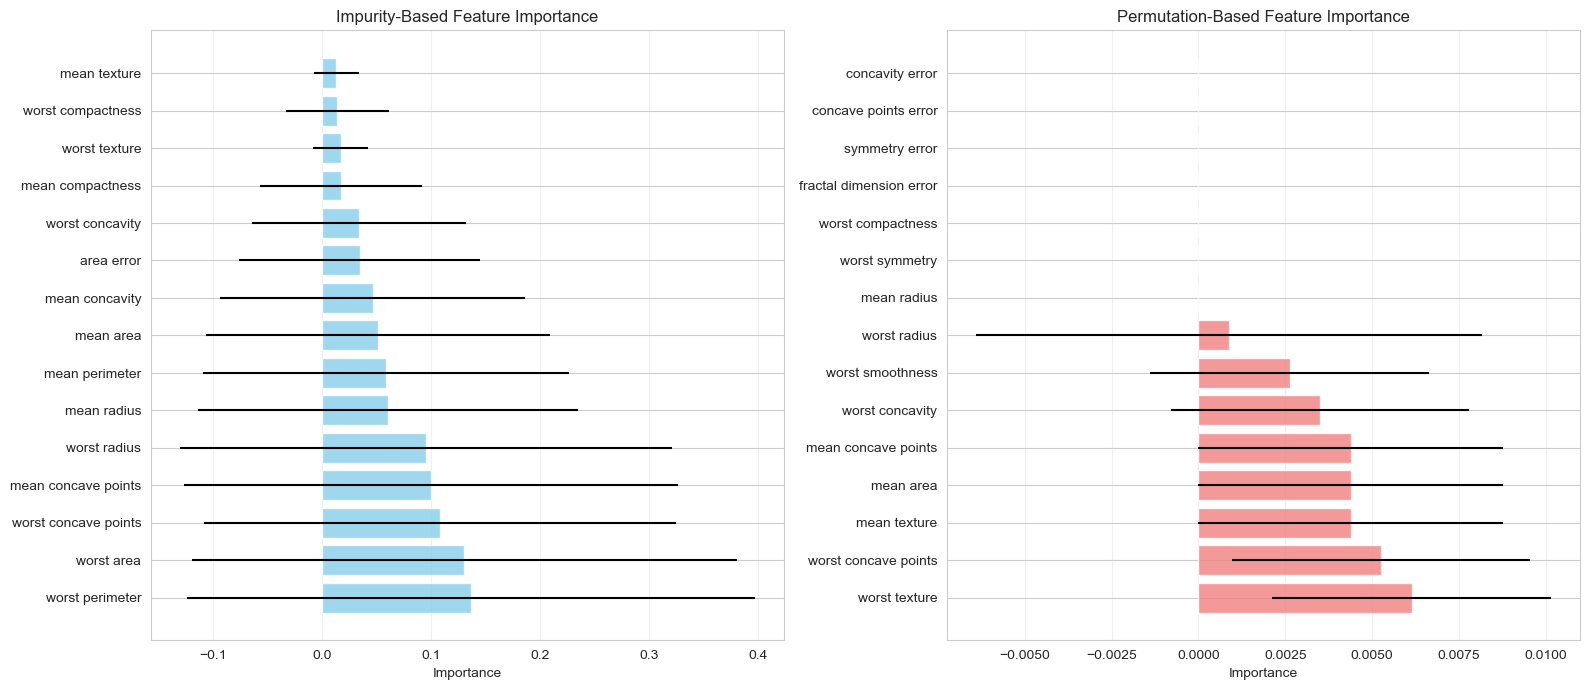


💡 Differences:
  - Impurity: Fast, based on training data splits
  - Permutation: Slower, based on actual predictions
  - Both provide similar rankings but different magnitudes


In [16]:
# Permutation importance
perm_importance = permutation_importance(
    rf_cancer, X_test_cancer, y_test_cancer,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_importance_df = pd.DataFrame({
    'Feature': cancer.feature_names,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values('Importance', ascending=False).head(15)

print("Permutation Importance (Top 15)")
print("="*70)
print(perm_importance_df.to_string(index=False))

print("\n💡 Permutation Importance:")
print("  - Shuffle each feature and measure performance drop")
print("  - More reliable than impurity-based importance")
print("  - Works with any model (model-agnostic)")
print("  - Accounts for feature interactions")

# Compare both importance methods
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Impurity-based
axes[0].barh(feature_importance_cancer['Feature'], 
            feature_importance_cancer['Importance'],
            xerr=feature_importance_cancer['Std'],
            alpha=0.8, color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Impurity-Based Feature Importance')
axes[0].grid(alpha=0.3, axis='x')

# Permutation-based
axes[1].barh(perm_importance_df['Feature'], 
            perm_importance_df['Importance'],
            xerr=perm_importance_df['Std'],
            alpha=0.8, color='lightcoral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Permutation-Based Feature Importance')
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n💡 Differences:")
print("  - Impurity: Fast, based on training data splits")
print("  - Permutation: Slower, based on actual predictions")
print("  - Both provide similar rankings but different magnitudes")

## Summary and Best Practices

### Quick Reference

```python
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

# Classification
rf_clf = RandomForestClassifier(
    n_estimators=100,       # Number of trees
    max_depth=10,          # Tree depth (None = unlimited)
    min_samples_split=5,   # Min samples to split
    min_samples_leaf=2,    # Min samples per leaf
    max_features='sqrt',   # Features per split
    oob_score=True,        # Out-of-bag validation
    n_jobs=-1,             # Parallel processing
    random_state=42
)

# Regression
rf_reg = RandomForestRegressor(
    n_estimators=100,
    max_features=0.33,     # 1/3 of features
    oob_score=True,
    n_jobs=-1,
    random_state=42
)

rf_clf.fit(X_train, y_train)
predictions = rf_clf.predict(X_test)
```

### Advantages

✓ **Robust**: Less overfitting than single trees
✓ **Accurate**: Often best out-of-box performance
✓ **Feature importance**: Built-in importance ranking
✓ **Handles missing values**: Can handle NaNs (implementation-dependent)
✓ **No scaling needed**: Tree-based, scale-invariant
✓ **Parallel**: Trees trained independently
✓ **OOB validation**: Built-in validation without separate set
✓ **Versatile**: Classification and regression

### Disadvantages

❌ **Black box**: Less interpretable than single tree
❌ **Memory**: Stores multiple trees
❌ **Slow prediction**: Must query all trees
❌ **Not extrapolate**: Cannot predict beyond training range

### Best Practices

1. ✓ **Start with defaults** (100 trees, sqrt features)
2. ✓ **Use OOB score** for quick validation
3. ✓ **Increase n_estimators** (200-500) if time permits
4. ✓ **Tune max_depth and min_samples** to control complexity
5. ✓ **Use RandomizedSearchCV** (faster than GridSearchCV)
6. ✓ **Check permutation importance** for robust feature ranking
7. ✓ **Enable parallel processing** (n_jobs=-1)
8. ✓ **Monitor OOB vs test** to verify generalization

### Key Hyperparameters

| Parameter | Classification | Regression | Effect |
|-----------|----------------|------------|--------|
| `n_estimators` | 100-500 | 100-500 | More trees = better (diminishing returns) |
| `max_features` | 'sqrt' | 0.33 (p/3) | Controls diversity |
| `max_depth` | 5-20 | 5-20 | Limits tree complexity |
| `min_samples_split` | 2-20 | 2-20 | Prevents overfitting |
| `min_samples_leaf` | 1-10 | 1-10 | Smooths predictions |
| `oob_score` | True | True | Built-in validation |

### When to Use Random Forest

✓ **Good for:**
- Tabular data with mixed feature types
- Need robust baseline model
- Feature importance analysis required
- Small to medium datasets
- Don't want to tune hyperparameters much
- Need uncertainty estimates (via prediction variance)

✗ **Consider alternatives:**
- Very large datasets → LightGBM, XGBoost (faster)
- Need highest accuracy → Gradient Boosting
- Need interpretability → Single Decision Tree, Linear Models
- Text/Image data → Deep Learning
- Time series → ARIMA, LSTM

### Comparison: Random Forest vs Gradient Boosting

| Aspect | Random Forest | Gradient Boosting |
|--------|---------------|-------------------|
| Training | Parallel (fast) | Sequential (slower) |
| Overfitting | Resistant | Prone (needs tuning) |
| Hyperparameters | Few to tune | Many to tune |
| Accuracy | Good | Often better |
| Robustness | More robust | Less robust |
| Use case | Quick baseline | Competition winning |

### Next Steps

- Gradient Boosting (GBM, XGBoost, LightGBM)
- SHAP values for detailed interpretation
- Handling imbalanced data
- Stacking and blending ensembles
- Feature engineering for trees